In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve)
import time

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_10112\2059066818.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Data Exploration

In [2]:
# load data

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                'marital-status', 'occupation', 'relationship', 'race', 
                'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
                'native-country', 'income']
df = pd.read_csv('Census Income Data Set/adult.data',names=column_names,na_values=' ?',skipinitialspace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [3]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df_missing = (df=='?').sum()
df_missing

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

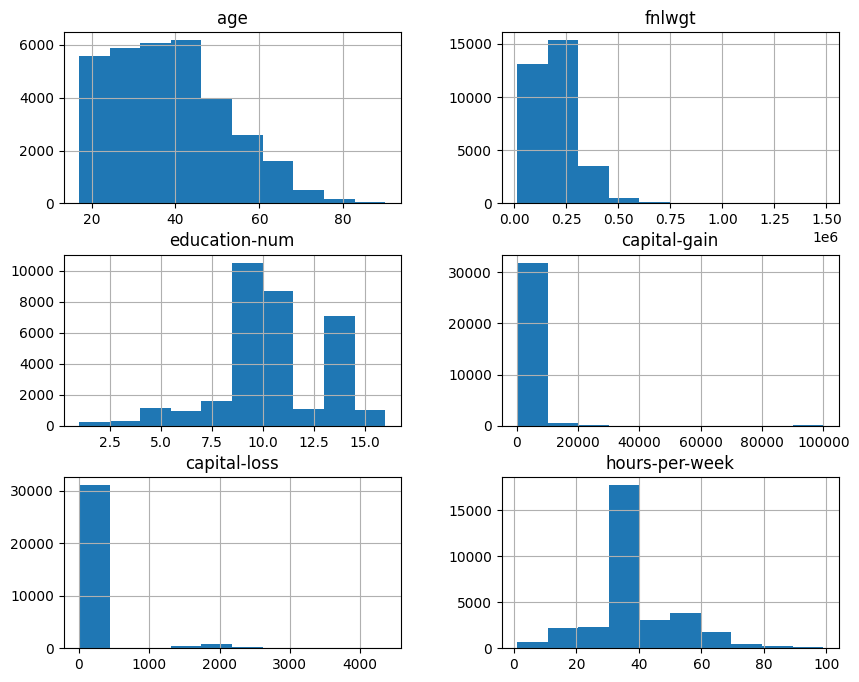

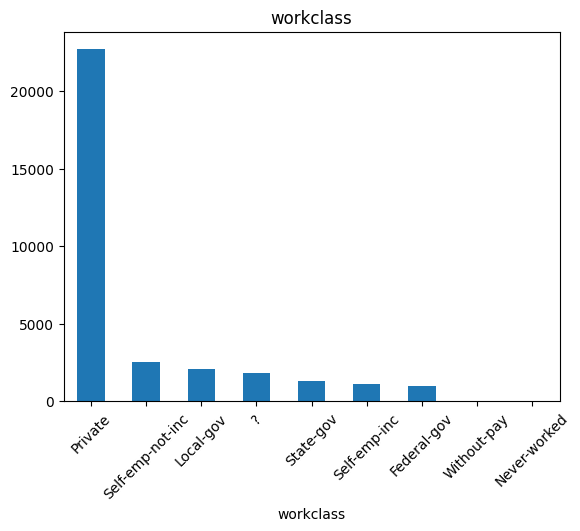

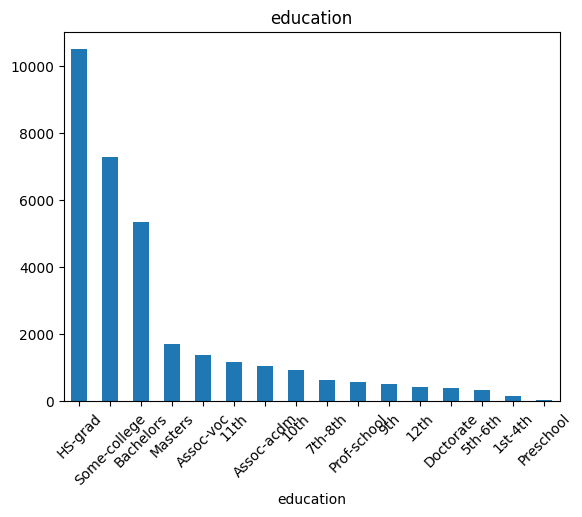

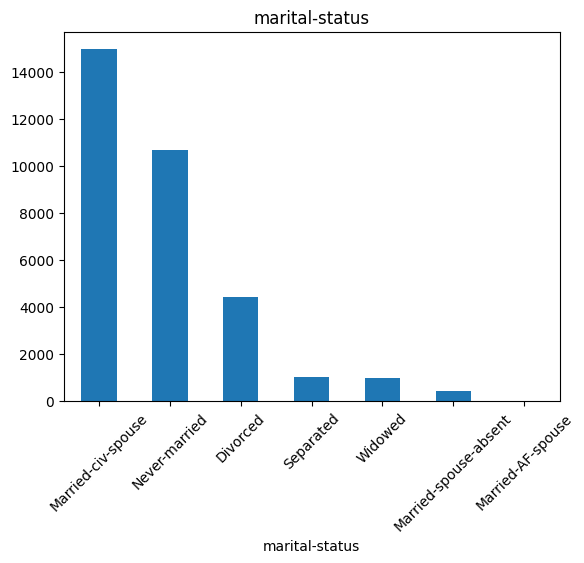

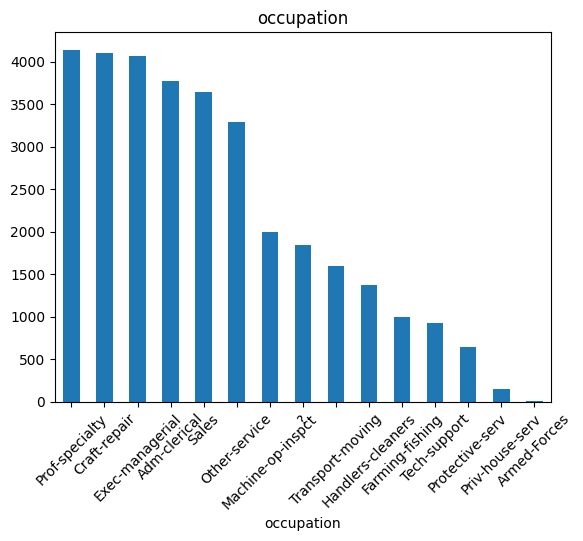

In [6]:
# Numeric attributes
df.hist(figsize=(10, 8))
plt.show()

# Classification attributes(some)
for col in df.select_dtypes(include='object').columns[:4]:
    df[col].value_counts().plot(kind='bar', title=col)
    plt.xticks(rotation=45)
    plt.show()

load data

In [7]:
def load_census_data():

    try:
        # load data Feature's name come from adult.name 
        column_names = [
            'age', 'workclass', 'fnlwgt', 'education', 'education-num', 
            'marital-status', 'occupation', 'relationship', 'race', 'sex', 
            'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
        ]
        
        # read training data 
        train_data = pd.read_csv(
            'Census Income Data Set/adult.data', 
            names=column_names, 
            na_values=' ?', 
            skipinitialspace=True
        )
        
        # read testing data 
        test_data = pd.read_csv(
            'Census Income Data Set/adult.test', 
            names=column_names, 
            na_values=' ?', 
            skipinitialspace=True,
            skiprows=1  # skip the first line(title)
        )
        return train_data, test_data, column_names
    
    except FileNotFoundError as e:
        print(f"can't find the file: {e}")
        return None, None, None


data preprocess

In [8]:
def preprocess_data(train_data, test_data):
    
    # Create a copy of your data
    train_clean = train_data.copy()
    test_clean = test_data.copy()
    
    
    # Process the target variable (remove periods, unify format)
    train_clean['income'] = train_clean['income'].str.strip()
    test_clean['income'] = test_clean['income'].str.replace('.', '').str.strip()
    
    #Handling missing values ​​for categorical features (filling with mode)
    categorical_cols = ['workclass', 'occupation', 'native-country']
    
    for col in categorical_cols:
        if col in train_clean.columns:
            train_mode = train_clean[col].mode()[0]
            train_clean[col].fillna(train_mode, inplace=True)
            test_clean[col].fillna(train_mode, inplace=True)  # Use the majority
    
    
    #Feature Engineering
    # for age data,creat a group to devide
    def age_group(age):
        if age < 25:
            return 'Young'
        elif age < 45:
            return 'Adult'
        elif age < 65:
            return 'Senior'
        else:
            return 'Elderly'
    
    train_clean['age_group'] = train_clean['age'].apply(age_group)
    test_clean['age_group'] = test_clean['age'].apply(age_group)
    
    # for working time,too
    def hours_group(hours):
        if hours < 30:
            return 'Part-time'
        elif hours < 40:
            return 'Full-time'
        elif hours == 40:
            return 'Standard'
        else:
            return 'Overtime'
    
    train_clean['hours_group'] = train_clean['hours-per-week'].apply(hours_group)
    test_clean['hours_group'] = test_clean['hours-per-week'].apply(hours_group)
    
    # capital loss and gain
    train_clean['has_capital_gain'] = (train_clean['capital-gain'] > 0).astype(int)
    test_clean['has_capital_gain'] = (test_clean['capital-gain'] > 0).astype(int)
    
    train_clean['has_capital_loss'] = (train_clean['capital-loss'] > 0).astype(int)
    test_clean['has_capital_loss'] = (test_clean['capital-loss'] > 0).astype(int)
    
    
    return train_clean, test_clean

# encode and scale
def encode_and_scale(train_data, test_data):
    
    # final features
    categorical_features = [
        'workclass', 'education', 'marital-status', 'occupation', 
        'relationship', 'race', 'sex', 'native-country',
        'age_group', 'hours_group'
    ]
    
    numerical_features = [
        'age', 'fnlwgt', 'education-num', 'capital-gain', 
        'capital-loss', 'hours-per-week', 'has_capital_gain', 'has_capital_loss'
    ]
    
    # One-Hot encoding of categorical features
    train_encoded = pd.get_dummies(train_data, columns=categorical_features, drop_first=True)
    test_encoded = pd.get_dummies(test_data, columns=categorical_features, drop_first=True)
    
    #make sure train data and test data have the same cols
    train_cols = set(train_encoded.columns)
    test_cols = set(test_encoded.columns)
    
    for col in train_cols - test_cols:
        if col != 'income':
            test_encoded[col] = 0
    
    for col in test_cols - train_cols:
        if col != 'income':
            train_encoded[col] = 0
    
    test_encoded = test_encoded[train_encoded.columns]
    
    
    #Separating features and target variables
    X_train = train_encoded.drop('income', axis=1)
    y_train = train_encoded['income']
    X_test = test_encoded.drop('income', axis=1)
    y_test = test_encoded['income']
    
    #Normalizing Numerical Features
    scaler = StandardScaler()
    
    # standardization
    numerical_cols_in_encoded = [col for col in numerical_features if col in X_train.columns]
    
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numerical_cols_in_encoded] = scaler.fit_transform(X_train[numerical_cols_in_encoded])
    X_test_scaled[numerical_cols_in_encoded] = scaler.transform(X_test[numerical_cols_in_encoded])
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

    
def main():
    # load data
    train_data, test_data, column_names = load_census_data()
    
    if train_data is None:
        return
    
    # preprocess
    train_clean, test_clean = preprocess_data(train_data, test_data)
    
    # encoding and scale
    X_train, X_test, y_train, y_test, scaler = encode_and_scale(train_clean, test_clean)
    
    return X_train, X_test, y_train, y_test, scaler


In [9]:
def basic_decision_tree(X_train, X_test, y_train, y_test):
    print("prepare data")
    
    if hasattr(y_train, 'dtype'):
        is_numeric = np.issubdtype(y_train.dtype, np.number)
    else:
        is_numeric = False

    if not is_numeric:
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)
    else:
        
        le = LabelEncoder()
        le.classes_ = np.array(['<=50K', '>50K'])  
        y_train_encoded = y_train
        y_test_encoded = y_test
    
    print("\n-----training-----")
    start_time = time.time()
    
    dt_default = DecisionTreeClassifier(max_depth=5, random_state=100)
    dt_default.fit(X_train, y_train_encoded)
    
    training_time = time.time() - start_time
    print(f"Model training is completed, time-consuming: {training_time:.2f}s")
    
    print("\n-----predicting-----")
    start_time = time.time()
    y_pred = dt_default.predict(X_test)
    y_pred_proba = dt_default.predict_proba(X_test)[:, 1]
    prediction_time = time.time() - start_time
    
    print(f"Prediction completed, time consuming: {prediction_time:.2f}s")
    
    return dt_default, le, y_pred, y_pred_proba, training_time, prediction_time, y_test_encoded

def evaluate_model(model, le, y_test_encoded, y_pred, y_pred_proba):
    print("\n-----evaluation-----")
    
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred)
    recall = recall_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print(classification_report(y_test_encoded, y_pred, 
                              target_names=le.classes_))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

def visualize_results(model, le, X_test, y_test_encoded, y_pred, y_pred_proba, feature_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. confusion_matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0, 0])
    axes[0, 0].set_title('confusion matrix')
    axes[0, 0].set_xlabel('predict label')
    axes[0, 0].set_ylabel('true label')
    
    # 2. ROC curve
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                   label=f'ROC Curve (AUC = {roc_auc_score(y_test_encoded, y_pred_proba):.3f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(True)
    
    # 3. feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    axes[1, 0].barh(range(len(feature_importance)), feature_importance['importance'])
    axes[1, 0].set_yticks(range(len(feature_importance)))
    axes[1, 0].set_yticklabels(feature_importance['feature'])
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title('Top 10 Feature Importances')
    axes[1, 0].invert_yaxis()
    
    # 4. Performance Metrics Comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    values = [
        accuracy_score(y_test_encoded, y_pred),
        precision_score(y_test_encoded, y_pred),
        recall_score(y_test_encoded, y_pred),
        f1_score(y_test_encoded, y_pred)
    ]
    
    bars = axes[1, 1].bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Model Performance Metrics')
    axes[1, 1].set_ylim(0, 1)
    
    for bar, value in zip(bars, values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def show_tree_structure(model, feature_names, class_names):
   
    print("\n-----decision tree-----")
    
    tree_depth = model.get_depth()
    tree_leaves = model.get_n_leaves()
    n_features = model.n_features_in_
    
    print(f"Tree depth: {tree_depth}")
    print(f"Number of leaf nodes: {tree_leaves}")
    print(f"Number of features used: {n_features}")
    
    # Plot decision tree
    plt.figure(figsize=(15, 8))
    plot_tree(model, 
              feature_names=feature_names,
              class_names=class_names,
              filled=True, 
              rounded=True,
              max_depth=5,  
              fontsize=10)
    plt.title('Decision Tree Structure', fontsize=14)
    plt.show()

def run_basic_decision_tree(X_train, X_test, y_train, y_test):
    feature_names = X_train.columns.tolist()
    
    dt_model, le, y_pred, y_pred_proba, train_time, pred_time, y_test_encoded = basic_decision_tree(
        X_train, X_test, y_train, y_test
    )
    
    eval_results = evaluate_model(dt_model, le, y_test_encoded, y_pred, y_pred_proba)
    
    feature_importance = visualize_results(
        dt_model, le, X_test, y_test_encoded, y_pred, y_pred_proba, feature_names
    )
    
    show_tree_structure(dt_model, feature_names, le.classes_)
    
    print(f"\n{'='*50}")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Prediction time: {pred_time:.2f} seconds")
    print(f"Test set accuracy: {eval_results['accuracy']:.4f}")
    print(f"Test set F1-score: {eval_results['f1']:.4f}")
    print(f"ROC-AUC: {eval_results['roc_auc']:.4f}")
    print(f"\nTop 5 most important features:")
    print(feature_importance.head(5))
    
    return {
        'model': dt_model,
        'label_encoder': le,
        'predictions': y_pred,
        'prediction_proba': y_pred_proba,
        'evaluation': eval_results,
        'feature_importance': feature_importance
    }





In [10]:
def optimize_hyperparameters(X_train, y_train):
  
    
    if hasattr(y_train, 'dtype'):
        is_numeric = np.issubdtype(y_train.dtype, np.number)
    else:
        is_numeric = False

    if not is_numeric:
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
    else:
        y_train_encoded = y_train
    
    param_grid = {
        'max_depth': range(1, 30),
        'min_samples_leaf': [1, 5, 10, 20, 50],
        'min_samples_split': [2, 5, 10, 20],
        'criterion': ['gini', 'entropy']
    }
    
    dtree = DecisionTreeClassifier(random_state=100)
    grid_search = GridSearchCV(
        dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train_encoded)
    
    print(f"\nbest params: {grid_search.best_params_}")
    print(f"best score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.best_params_

In [11]:
def final_decision_tree(X_train, X_test, y_train, y_test, best_params):
    print("prepare data")
    
    if hasattr(y_train, 'dtype'):
        is_numeric = np.issubdtype(y_train.dtype, np.number)
    else:
        is_numeric = False

    if not is_numeric:
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)
    else:
        le = LabelEncoder()
        le.classes_ = np.array(['<=50K', '>50K'])
        y_train_encoded = y_train
        y_test_encoded = y_test
    
    print("\n-----training-----")
    start_time = time.time()
    
    final_model = DecisionTreeClassifier(
        criterion=best_params.get('criterion', 'gini'),
        max_depth=best_params['max_depth'],
        min_samples_leaf=best_params['min_samples_leaf'],
        min_samples_split=best_params['min_samples_split'],
        random_state=100
    )
    final_model.fit(X_train, y_train_encoded)
    
    training_time = time.time() - start_time
    print(f"Model training is completed, time-consuming: {training_time:.2f}s")
    
    print("\n-----predicting-----")
    start_time = time.time()
    y_pred = final_model.predict(X_test)
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    prediction_time = time.time() - start_time
    
    print(f"Prediction completed, time consuming: {prediction_time:.2f}s")
    
    return final_model, le, y_pred, y_pred_proba, training_time, prediction_time, y_test_encoded

In [12]:
def run_final_decision_tree(X_train, X_test, y_train, y_test, best_params=None):
    feature_names = X_train.columns.tolist()
    
    if best_params is None:
        _, best_params = optimize_hyperparameters(X_train, y_train)
    

    dt_model, le, y_pred, y_pred_proba, train_time, pred_time, y_test_encoded = final_decision_tree(
        X_train, X_test, y_train, y_test, best_params
    )
    

    eval_results = evaluate_model(dt_model, le, y_test_encoded, y_pred, y_pred_proba)
    
    feature_importance = visualize_results(
        dt_model, le, X_test, y_test_encoded, y_pred, y_pred_proba, feature_names
    )
    

    show_tree_structure(dt_model, feature_names, le.classes_)
    
    print(f"\n{'='*50}")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Prediction time: {pred_time:.2f} seconds")
    print(f"Test set accuracy: {eval_results['accuracy']:.4f}")
    print(f"Test set F1-score: {eval_results['f1']:.4f}")
    print(f"ROC-AUC: {eval_results['roc_auc']:.4f}")
    print(f"\nTop 5 most important features:")
    print(feature_importance.head(5))
    
    return {
        'model': dt_model,
        'label_encoder': le,
        'predictions': y_pred,
        'prediction_proba': y_pred_proba,
        'evaluation': eval_results,
        'feature_importance': feature_importance,
        'best_params': best_params
    }



C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_10112\326435178.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean[col].fillna(train_mode, inplace=True)
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_10112\326435178.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 


basic decision tree
prepare data

-----training-----
Model training is completed, time-consuming: 0.16s

-----predicting-----
Prediction completed, time consuming: 0.02s

-----evaluation-----
Accuracy: 0.8520
Precision: 0.7795
Recall: 0.5211
F1-score: 0.6246
ROC-AUC: 0.8831
              precision    recall  f1-score   support

       <=50K       0.87      0.95      0.91     12435
        >50K       0.78      0.52      0.62      3846

    accuracy                           0.85     16281
   macro avg       0.82      0.74      0.77     16281
weighted avg       0.85      0.85      0.84     16281



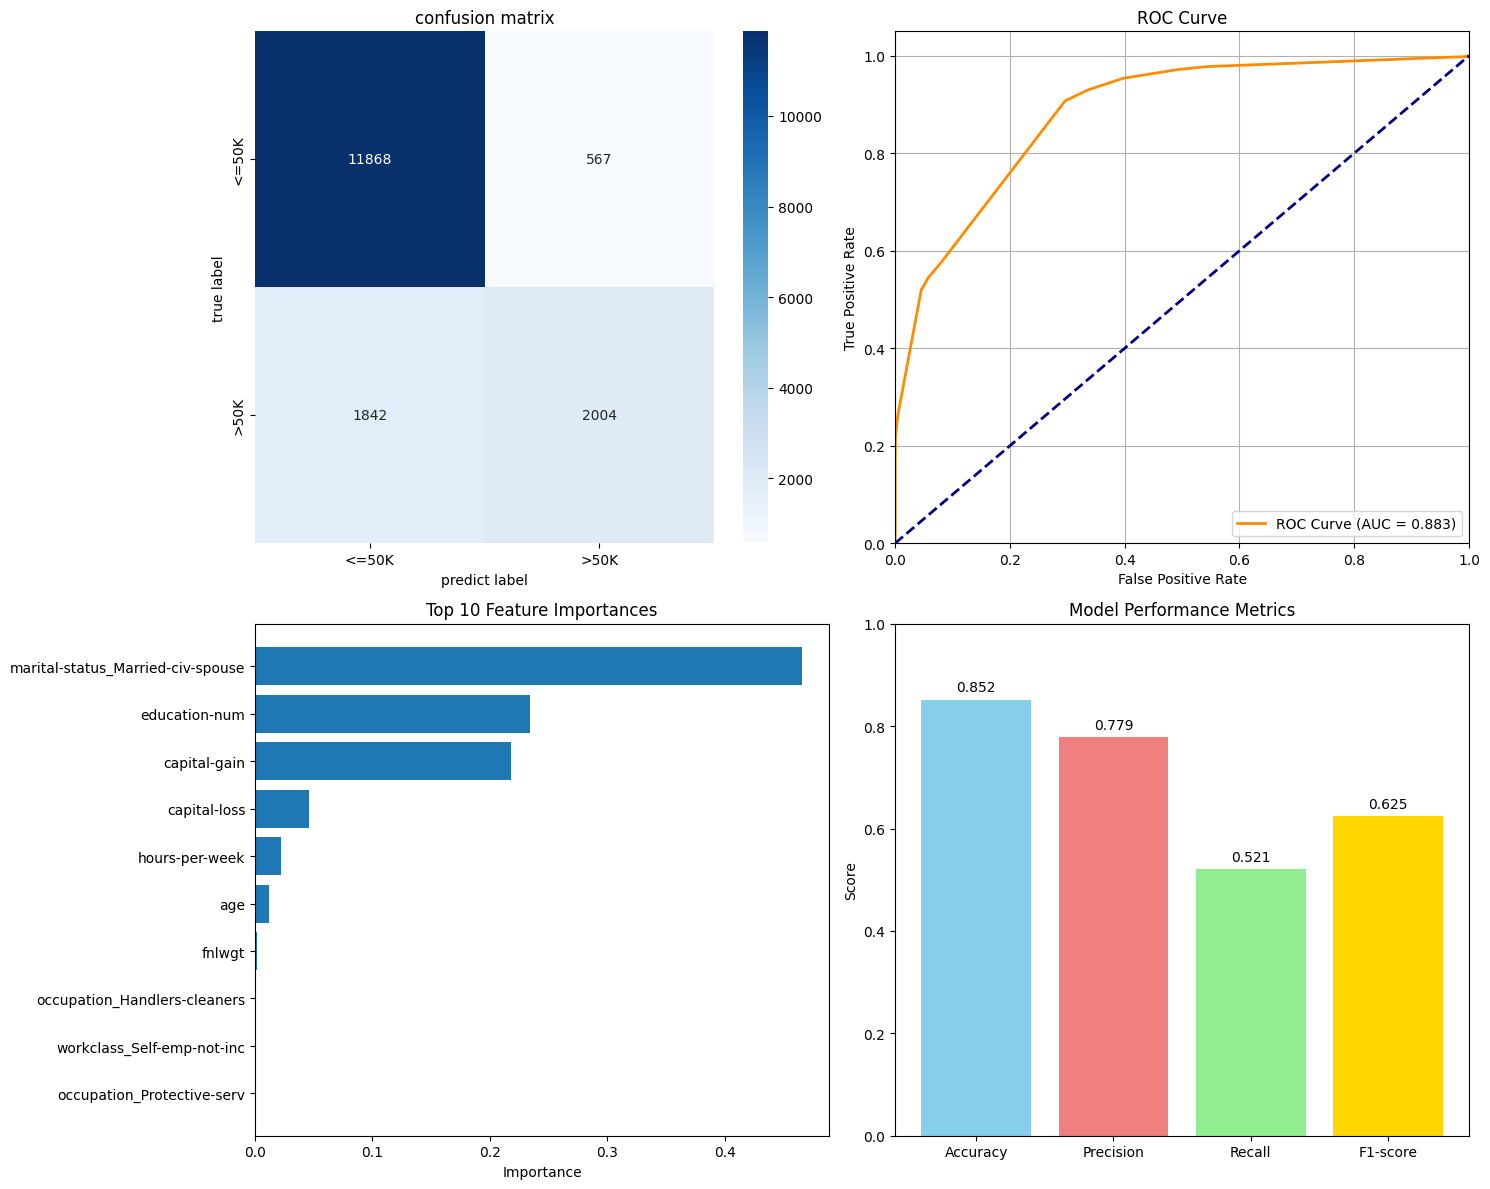


-----decision tree-----
Tree depth: 5
Number of leaf nodes: 28
Number of features used: 108


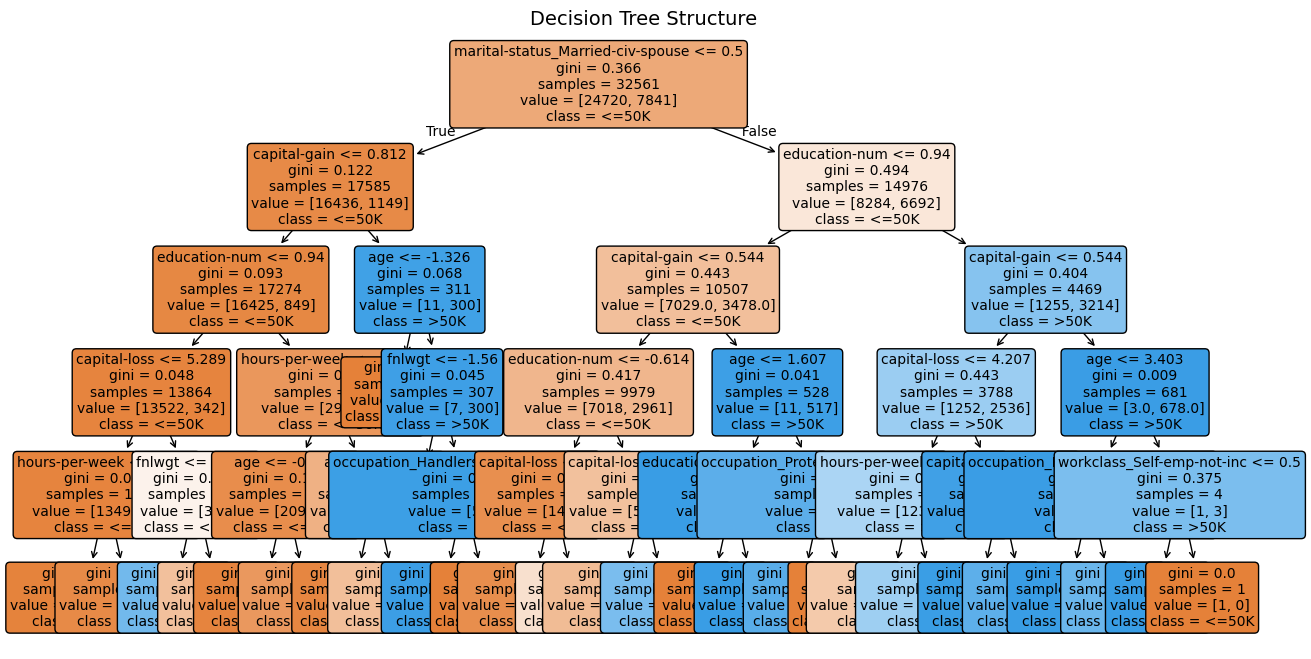


Training time: 0.16 seconds
Prediction time: 0.02 seconds
Test set accuracy: 0.8520
Test set F1-score: 0.6246
ROC-AUC: 0.8831

Top 5 most important features:
                              feature  importance
32  marital-status_Married-civ-spouse    0.465496
2                       education-num    0.233963
3                        capital-gain    0.217871
4                        capital-loss    0.046142
5                      hours-per-week    0.021999

final decision tree
Fitting 5 folds for each of 1160 candidates, totalling 5800 fits

best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
best score: 0.8570
prepare data

-----training-----
Model training is completed, time-consuming: 0.25s

-----predicting-----
Prediction completed, time consuming: 0.02s

-----evaluation-----
Accuracy: 0.8626
Precision: 0.7726
Recall: 0.5928
F1-score: 0.6709
ROC-AUC: 0.9065
              precision    recall  f1-score   support

       <=50K       0.88  

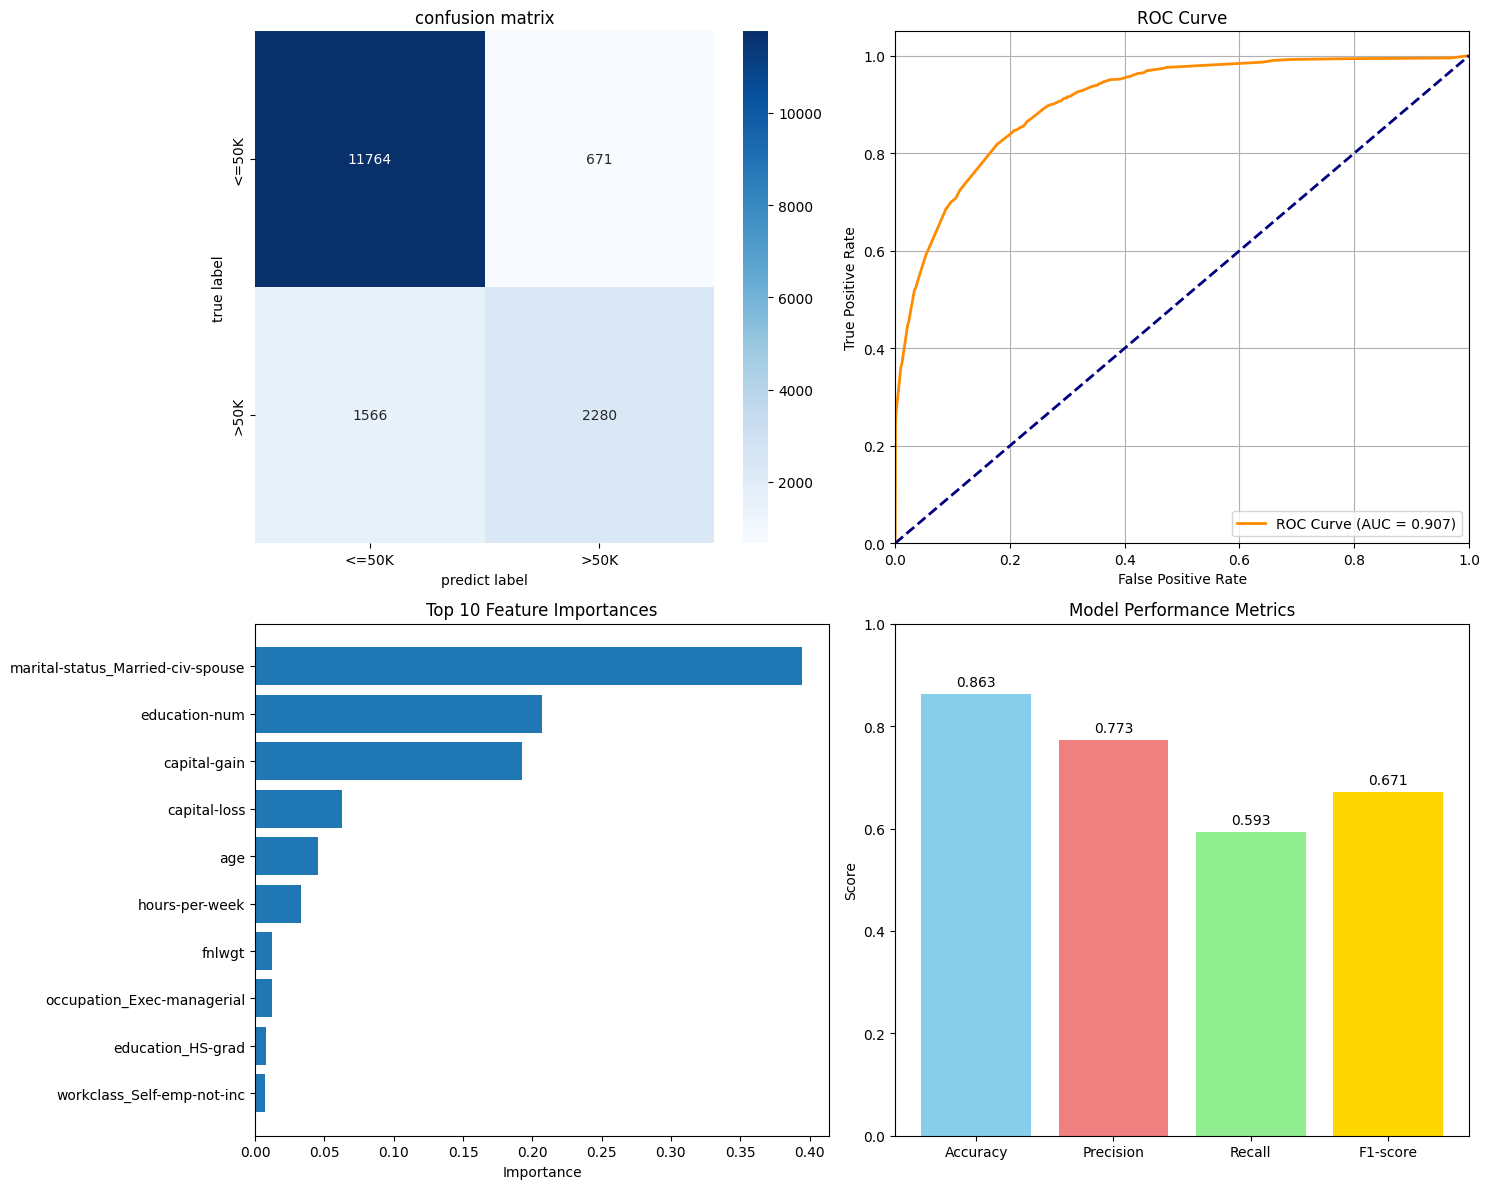


-----decision tree-----
Tree depth: 10
Number of leaf nodes: 231
Number of features used: 108


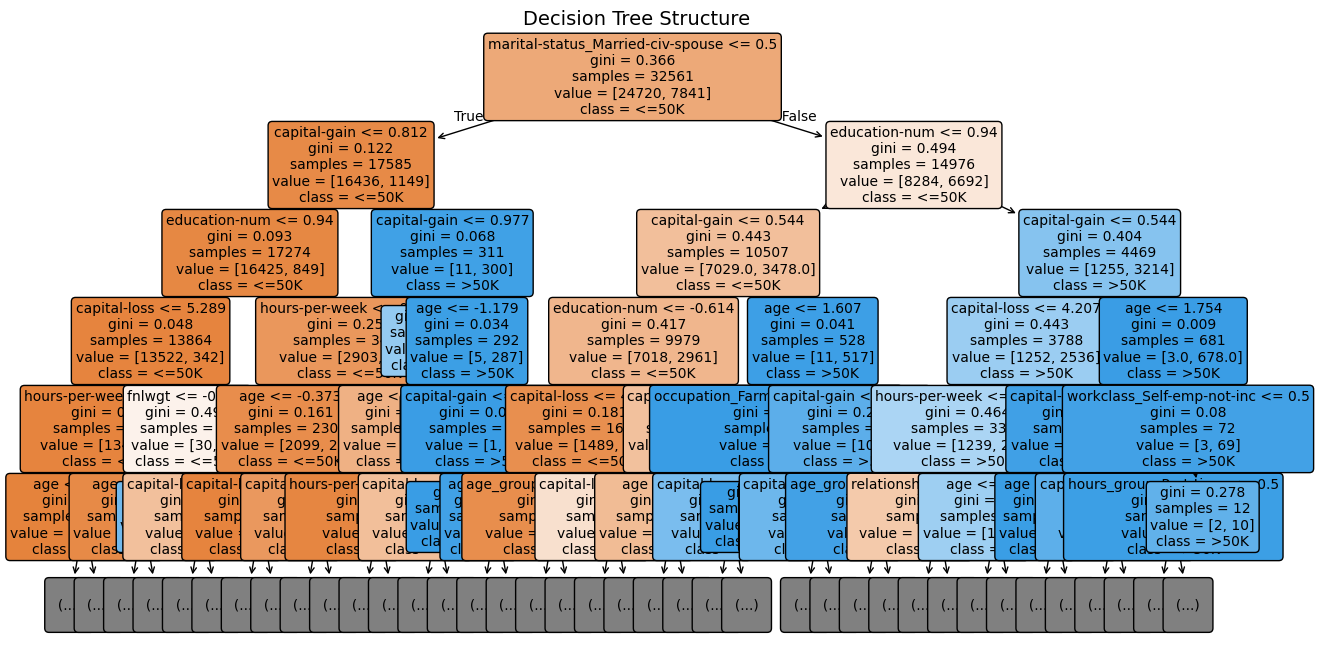


Training time: 0.25 seconds
Prediction time: 0.02 seconds
Test set accuracy: 0.8626
Test set F1-score: 0.6709
ROC-AUC: 0.9065

Top 5 most important features:
                              feature  importance
32  marital-status_Married-civ-spouse    0.394265
2                       education-num    0.206820
3                        capital-gain    0.192492
4                        capital-loss    0.062741
0                                 age    0.045333


In [13]:
X_train, X_test, y_train, y_test, scaler = main()

# basic decision tree
print("\n" + "="*70)
print("basic decision tree")
print("="*70)
basic_dt_results = run_basic_decision_tree(X_train, X_test, y_train, y_test)

# final decision tree
print("\n" + "="*70)
print("final decision tree")
print("="*70)
final_dt_results = run_final_decision_tree(X_train, X_test, y_train, y_test)